In [1]:
!pip install optuna
!pip install language_tool_python
!pip install phunspell
!pip install re

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, precision_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import optuna
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score
from random import randint
import warnings
from imblearn.over_sampling import SMOTE

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import language_tool_python
import phunspell
import re



In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import os
import sys

In [5]:
%cd drive/MyDrive/CS_4641_Project/
%ls

/content/drive/MyDrive/CS_4641_Project
another-page.md      docs/                     index.md                     README.md
assets/              fake_reviews_dataset.csv  jekyll-theme-cayman.gemspec  _sass/
Categories.png       final_code.ipynb          Label.png                    script/
cleaned_reviews.csv  final.md                  _layouts/                    _site/
code/                Gemfile                   LICENSE                      thumbnail.png
_config.yml          Gemfile.lock              midterm.md
data_cleaner.py      image.jpg                 proposal.md
docker-compose.yml   _includes/                Ratings.png


In [6]:
#data cleaning
data = pd.read_csv('cleaned_reviews.csv')
data['label'] = data['label'].replace({'CG': 1, 'OR': 0})

print(data['label'].value_counts())

"""
Renaming our category columns
id                  category
0   1    Home_and_Kitchen_5
1   2    Sports_and_Outdoors_5
2   3    Electronics_5
3   4    Movies_and_TV_5
4   5    Tools_and_Home_Improvement_5
5   6    Pet_Supplies_5
6   7    Kindle_Store_5
7   8    Books_5
8   9    Toys_and_Games_5
9  10    Clothing_Shoes_and_Jewelry_5
"""
unique_categories = data['category'].unique()
print(unique_categories)

data['category_numeric'] = pd.factorize(data['category'])[0]
data.rename(columns={'text_': 'text'}, inplace=True)

#use 1% of data for testing
#data = data.sample(frac=0.01)

data

0    20216
1     4043
Name: label, dtype: int64
['Home_and_Kitchen_5' 'Sports_and_Outdoors_5' 'Electronics_5'
 'Movies_and_TV_5' 'Tools_and_Home_Improvement_5' 'Pet_Supplies_5'
 'Kindle_Store_5' 'Books_5' 'Toys_and_Games_5'
 'Clothing_Shoes_and_Jewelry_5']


,category,rating,label,text,category_numeric
0,Home_and_Kitchen_5,5.0,1,Very nice set. Good quality. We have had the s...,0
1,Home_and_Kitchen_5,5.0,1,They are the perfect touch for me and the only...,0
2,Home_and_Kitchen_5,3.0,1,These done fit well and look great. I love th...,0
3,Home_and_Kitchen_5,1.0,1,These are so flimsy! They are not the quality ...,0
4,Home_and_Kitchen_5,5.0,1,it is exactly as pictured. I love the look and...,0
...,...,...,...,...,...
24254,Clothing_Shoes_and_Jewelry_5,4.0,0,This is a classy looking watch. I don't get m...,9
24255,Clothing_Shoes_and_Jewelry_5,5.0,0,The stated dimensions on the description are o...,9
24256,Clothing_Shoes_and_Jewelry_5,4.0,0,I had read some reviews saying that this bra r...,9
24257,Clothing_Shoes_and_Jewelry_5,2.0,0,"You can wear the hood by itself, wear it with ...",9


In [7]:
#feature engineering

#length of review
data['review_char_length'] = data['text'].apply(len)


#sentiment analysis for postive or negative
nltk.download('vader_lexicon')

def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)

    # label if the text is a postive, negative, or netural review

    if sentiment['compound'] >= 0.05 :
        return 1

    elif sentiment['compound'] <= -0.05 :
        return -1

    else :
        return 0

data['sentiment_score'] = data['text'].apply(get_sentiment)

print(data['sentiment_score'].value_counts())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


 1    20415
-1     2898
 0      946
Name: sentiment_score, dtype: int64


In [8]:
#word count

def count_words(string):
    # Split the string into words
    words = string.split()

    # Return the number of words
    return len(words)

# Create a new feature word_count
data['word_count'] = data['text'].apply(count_words)

In [9]:
#count spelling errors

pspell = phunspell.Phunspell('en_US')

def check_for_errors(text):
    mispelled = pspell.lookup_list(re.split(r'\W+', text))
    return len(mispelled)  # The number of errors detected

data['error_count'] = data['text'].apply(check_for_errors)

print(data)

print(data['error_count'].value_counts())


                           category  rating  label  \
0                Home_and_Kitchen_5     5.0      1   
1                Home_and_Kitchen_5     5.0      1   
2                Home_and_Kitchen_5     3.0      1   
3                Home_and_Kitchen_5     1.0      1   
4                Home_and_Kitchen_5     5.0      1   
...                             ...     ...    ...   
24254  Clothing_Shoes_and_Jewelry_5     4.0      0   
24255  Clothing_Shoes_and_Jewelry_5     5.0      0   
24256  Clothing_Shoes_and_Jewelry_5     4.0      0   
24257  Clothing_Shoes_and_Jewelry_5     2.0      0   
24258  Clothing_Shoes_and_Jewelry_5     5.0      0   

                                                    text  category_numeric  \
0      Very nice set. Good quality. We have had the s...                 0   
1      They are the perfect touch for me and the only...                 0   
2      These done fit well and look great.  I love th...                 0   
3      These are so flimsy! They are no

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit the number of features
data_tfidf = tfidf_vectorizer.fit_transform(data['text'])
#data['vectorized_text'] = data_tfidf.toarray().tolist()
#print(data['vectorized_text'])

In [11]:
#run correlations
correlations = data.corr()['label']
sorted_correlations = correlations.sort_values(ascending=False)
print(sorted_correlations)

label                 1.000000
sentiment_score       0.024627
rating                0.004022
category_numeric     -0.005062
word_count           -0.061571
review_char_length   -0.083322
error_count          -0.122160
Name: label, dtype: float64


<ipython-input-11-e5a8782580ee>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()['label']


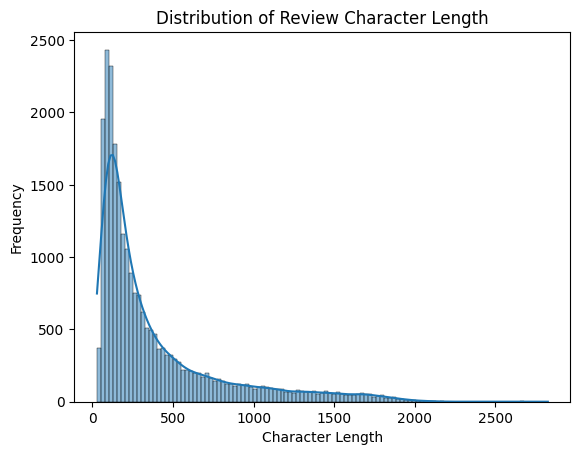

In [12]:
sns.histplot(data['review_char_length'], kde=True)
plt.title('Distribution of Review Character Length')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()

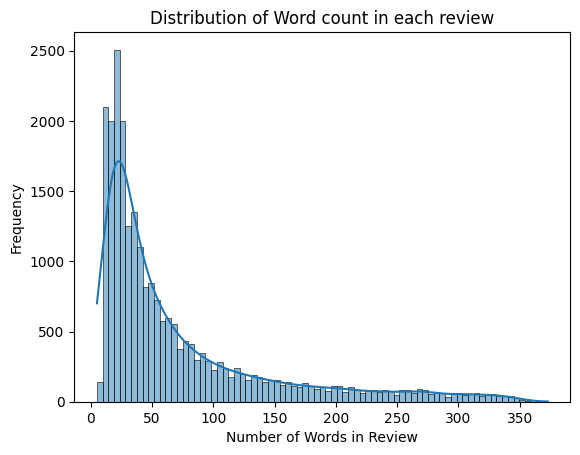

In [13]:
sns.histplot(data['word_count'], kde=True)
plt.title('Distribution of Word count in each review')
plt.xlabel('Number of Words in Review')
plt.ylabel('Frequency')
plt.show()

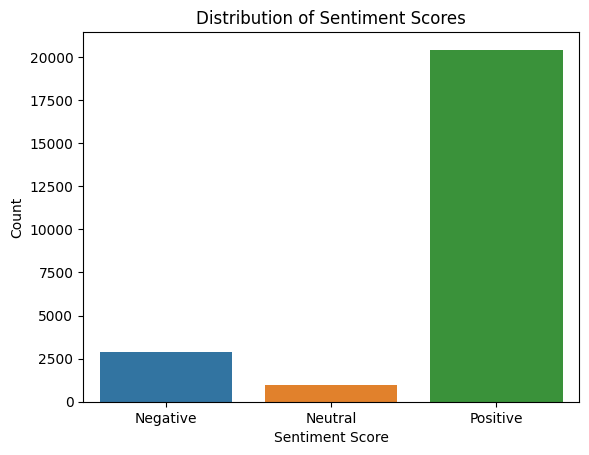

In [14]:
sentiment_counts = data['sentiment_score'].value_counts()

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])  # Adjust labels according to your coding
plt.show()

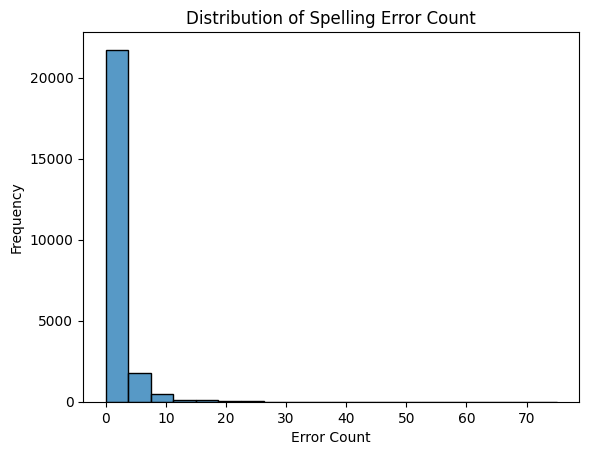

In [15]:
sns.histplot(data['error_count'], bins=20, kde=False)
plt.title('Distribution of Spelling Error Count')
plt.xlabel('Error Count')
plt.ylabel('Frequency')
plt.show()

In [16]:
#split data between training and validation
y = data["label"]
#drop non-numeric features
X = data.drop(["label", "category", "text"], axis=1)

x_train, x_test_validate, y_train, y_test_validate = train_test_split(X, y, test_size=0.2)

#use SMOTE to fill minority class
smote = SMOTE(sampling_strategy="minority")
x_smote, y_smote = smote.fit_resample(x_train, y_train)

In [27]:
#explore models
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, random_state=42, test_size=0.2)

df_models = pd.DataFrame(data=None, columns=['Algorithm', 'f1_train', 'f1_test'])

def make_model(X_tr, X_te, y_tr, y_te, model, model_name: str):
    X_tr = X_tr.astype(np.float32)
    X_te = X_te.astype(np.float32)
    y_tr = y_tr.astype(np.float32)
    y_te = y_te.astype(np.float32)
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    f1_train = f1_score(y_tr, y_pred_train, average='binary')
    f1_test = f1_score(y_te, y_pred_test, average='binary')
    df_models.loc[len(df_models.index)] = [model_name, f1_train, f1_test]


make_model(X_train, x_test_validate, y_train, y_test_validate, SVC(), 'SVC')
#make_model(X_train, X_test, y_train, y_test, GaussianProcessClassifier(), 'GaussianProcessClassifier')
make_model(X_train, x_test_validate, y_train, y_test_validate, DecisionTreeClassifier(), 'DecisionTreeClassifier')
make_model(X_train, x_test_validate, y_train, y_test_validate, RandomForestClassifier(), 'RandomForestClassifier')
make_model(X_train, x_test_validate, y_train, y_test_validate, GaussianNB(), 'GaussianNB')
#make_model(X_train, X_test, y_train, y_test, AdaBoostClassifier(), 'AdaBoostClassifier')
make_model(X_train, x_test_validate, y_train, y_test_validate, xgb.XGBClassifier(), 'XGBoost')

fig = go.Figure(data=[
    go.Bar(name='f1_train', x=df_models.Algorithm, y=df_models.f1_train),
    go.Bar(name='f1_test', x=df_models.Algorithm, y=df_models.f1_test)])

fig.update_layout(template='plotly_dark', title='f1 measure for train and test', title_x=0.5)

Best Accuracy: 0.78
Best Precision: 0.35
Best Recall: 0.38
Best ROC-AUC: 0.62


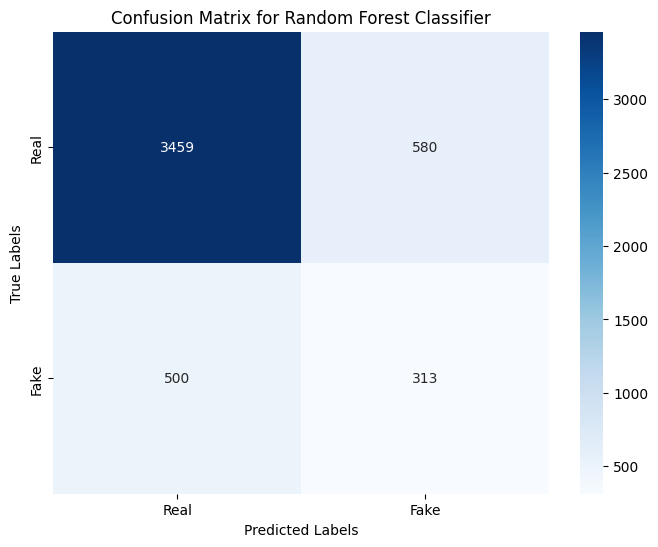

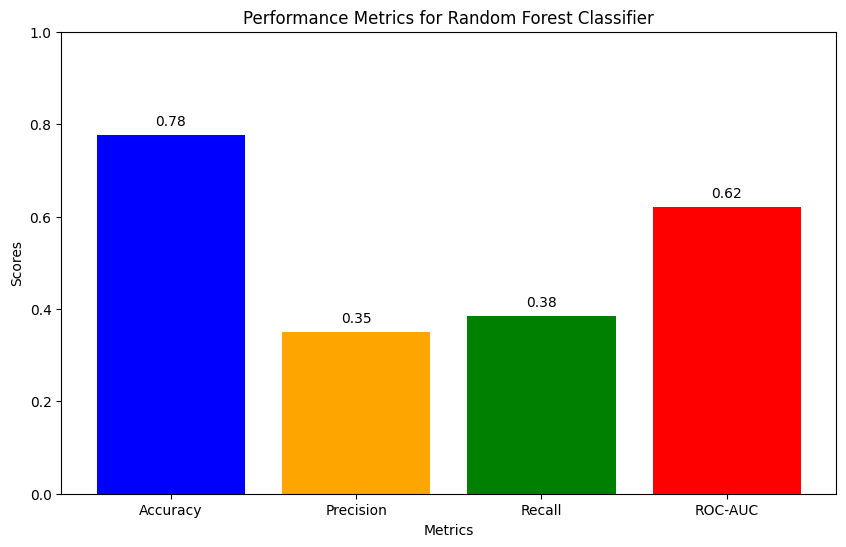

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(x_test_validate)

# Generate the confusion matrix
cm = confusion_matrix(y_test_validate, y_pred_rf)

best_accuracy = accuracy_score(y_test_validate, y_pred_rf)
best_precision = precision_score(y_test_validate, y_pred_rf)
best_recall = recall_score(y_test_validate, y_pred_rf)
best_roc_auc = roc_auc_score(y_test_validate, y_pred_rf)


# Print the metrics for the best estimator
print(f'Best Accuracy: {best_accuracy:.2f}')
print(f'Best Precision: {best_precision:.2f}')
print(f'Best Recall: {best_recall:.2f}')
print(f'Best ROC-AUC: {best_roc_auc:.2f}')

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

scores = [best_accuracy, best_precision, best_recall, best_roc_auc]
score_labels = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']

plt.figure(figsize=(10, 6))
plt.bar(score_labels, scores, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics for Random Forest Classifier')
plt.ylim(0, 1)  # Assuming the scores are between 0 and 1
for i in range(len(scores)):
    plt.text(i, scores[i] + 0.02, f'{scores[i]:.2f}', ha = 'center')
plt.show()

Best Accuracy: 0.74
Best Precision: 0.29
Best Recall: 0.41
Best ROC-AUC: 0.61


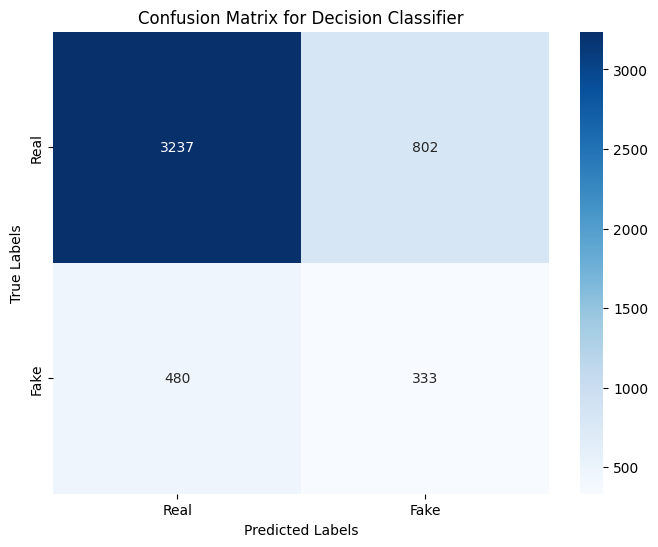

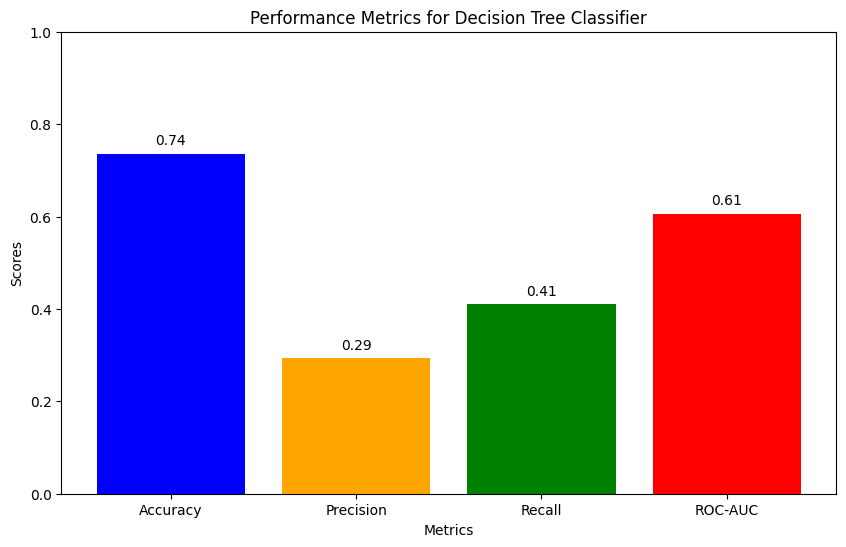

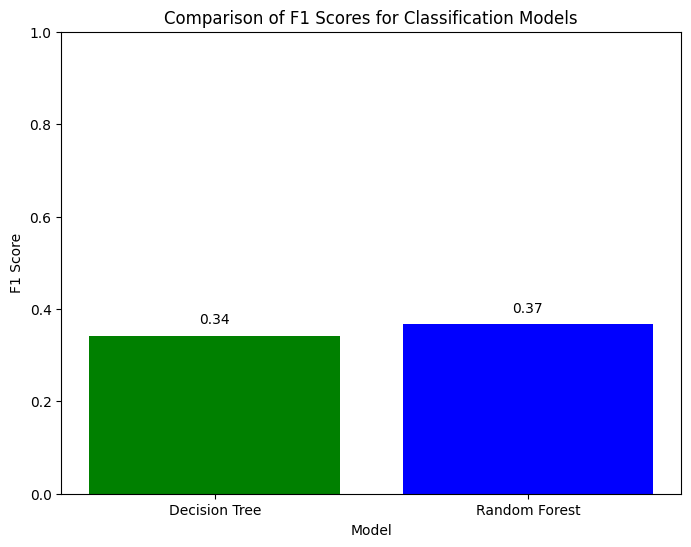

In [29]:
# Train the Decision Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = dt_classifier.predict(x_test_validate)

# Generate the confusion matrix
cm = confusion_matrix(y_test_validate, y_pred_dt)

best_accuracy = accuracy_score(y_test_validate, y_pred_dt)
best_precision = precision_score(y_test_validate, y_pred_dt)
best_recall = recall_score(y_test_validate, y_pred_dt)
best_roc_auc = roc_auc_score(y_test_validate, y_pred_dt)


# Print the metrics for the best estimator
print(f'Best Accuracy: {best_accuracy:.2f}')
print(f'Best Precision: {best_precision:.2f}')
print(f'Best Recall: {best_recall:.2f}')
print(f'Best ROC-AUC: {best_roc_auc:.2f}')

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix for Decision Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

scores = [best_accuracy, best_precision, best_recall, best_roc_auc]
score_labels = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']

plt.figure(figsize=(10, 6))
plt.bar(score_labels, scores, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics for Decision Tree Classifier')
plt.ylim(0, 1)  # Assuming the scores are between 0 and 1
for i in range(len(scores)):
    plt.text(i, scores[i] + 0.02, f'{scores[i]:.2f}', ha = 'center')
plt.show()

f1_dt = f1_score(y_test_validate, y_pred_dt)
f1_rf = f1_score(y_test_validate, y_pred_rf)

models = ['Decision Tree', 'Random Forest']
f1_scores = [f1_dt, f1_rf]

plt.figure(figsize=(8, 6))
plt.bar(models, f1_scores, color=['green', 'blue'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Classification Models')
plt.ylim(0, 1)

# Add the text with the F1 score on top of each bar
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')

plt.show()

Best Accuracy: 0.48
Best Precision: 0.23
Best Recall: 0.88
Best ROC-AUC: 0.64


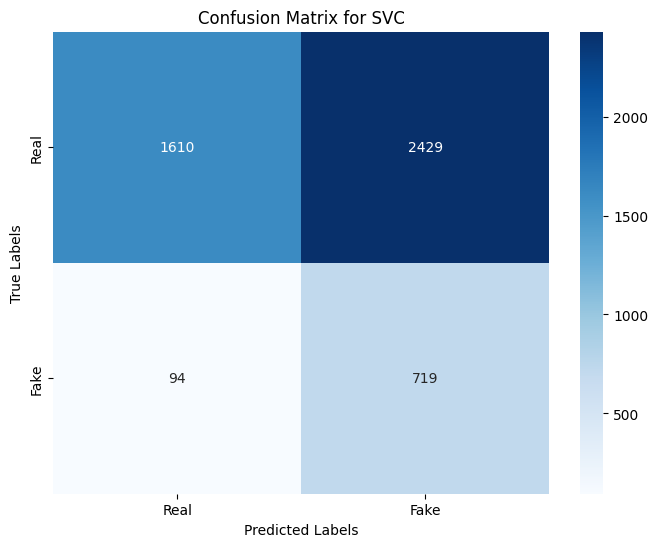

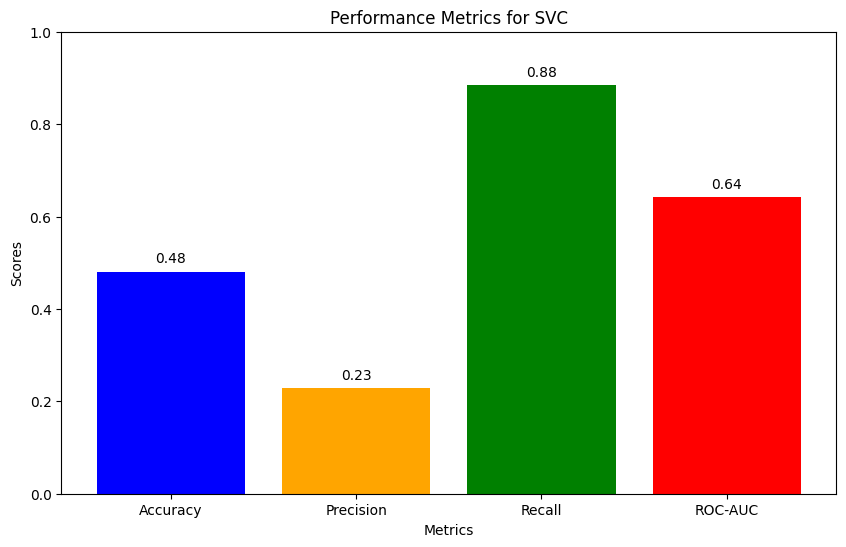

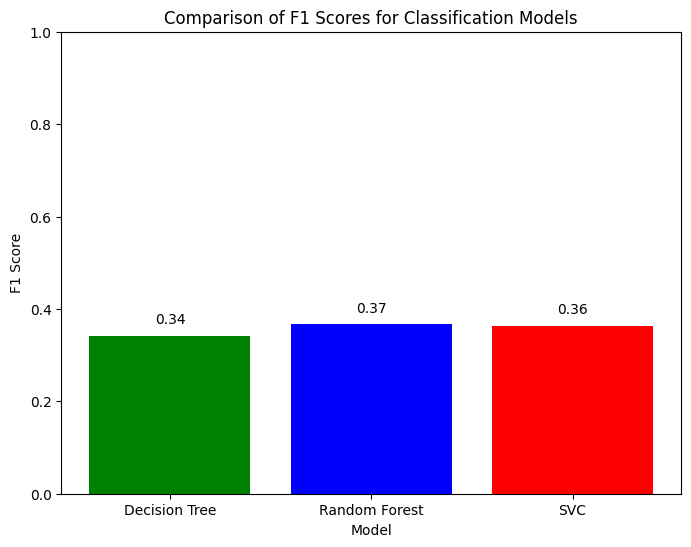

In [30]:
#Train the SVC
svc = SVC()
svc.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svc = svc.predict(x_test_validate)

# Generate the confusion matrix
cm = confusion_matrix(y_test_validate, y_pred_svc)

best_accuracy = accuracy_score(y_test_validate, y_pred_svc)
best_precision = precision_score(y_test_validate, y_pred_svc)
best_recall = recall_score(y_test_validate, y_pred_svc)
best_roc_auc = roc_auc_score(y_test_validate, y_pred_svc)


# Print the metrics for the best estimator
print(f'Best Accuracy: {best_accuracy:.2f}')
print(f'Best Precision: {best_precision:.2f}')
print(f'Best Recall: {best_recall:.2f}')
print(f'Best ROC-AUC: {best_roc_auc:.2f}')

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix for SVC")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

scores = [best_accuracy, best_precision, best_recall, best_roc_auc]
score_labels = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']

plt.figure(figsize=(10, 6))
plt.bar(score_labels, scores, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics for SVC')
plt.ylim(0, 1)  # Assuming the scores are between 0 and 1
for i in range(len(scores)):
    plt.text(i, scores[i] + 0.02, f'{scores[i]:.2f}', ha = 'center')
plt.show()

f1_dt = f1_score(y_test_validate, y_pred_dt)
f1_rf = f1_score(y_test_validate, y_pred_rf)
f1_svc = f1_score(y_test_validate, y_pred_svc)

models = ['Decision Tree', 'Random Forest', 'SVC']
f1_scores = [f1_dt, f1_rf, f1_svc]

plt.figure(figsize=(8, 6))
plt.bar(models, f1_scores, color=['green', 'blue', 'red'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Classification Models')
plt.ylim(0, 1)

# Add the text with the F1 score on top of each bar
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')

plt.show()

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Define the parameter distribution to sample from
param_distributions = {
    'C': reciprocal(0.001, 10),
    'gamma': expon(scale=1.0),
    'kernel': ['linear', 'rbf']
}

# Initialize the RandomizedSearchCV object
random_search_svc = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_distributions,
    n_iter=2,  # Number of parameter settings that are sampled
    cv=5,        # Number of folds in cross-validation
    verbose=1,
    n_jobs=-1,   # Use all available cores
    random_state=42
)

# Perform the RandomizedSearchCV
random_search_svc.fit(X_train, y_train)

# Get the best estimator
best_svc = random_search_svc.best_estimator_

# Make predictions with the best estimator
best_y_pred_svc = best_svc.predict(X_test)

# Calculate the confusion matrix with the best estimator
best_cm_svc = confusion_matrix(y_test, best_y_pred_svc)

# Visualize the confusion matrix of the best estimator
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm_svc, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Best Confusion Matrix for SVC after Hyperparameter Tuning")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Fitting 5 folds for each of 2 candidates, totalling 10 fits


KeyboardInterrupt: ignored

In [32]:

def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(x_smote, y_smote, test_size=0.2)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(x_test_validate, label=y_test_validate)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)


    optuna_model = xgb.XGBClassifier(**param)
    optuna_model.fit(train_x, train_y)
    y_pred = optuna_model.predict(x_test_validate)

    #precision=precision_score(test_y, y_pred)
    #fbeta = f1_score(test_y, y_pred, average='binary')
    fbeta = fbeta_score(y_test_validate, y_pred, average='binary', pos_label = 1, beta = 0.75)
    # using an f-beta less than 1 because we want to reduce false positives
    return fbeta

In [33]:
warnings.filterwarnings('ignore')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 25, show_progress_bar=True)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-12-06 01:28:15,144] A new study created in memory with name: no-name-35dda8a6-8607-4c26-bab2-29d28d53cd8f


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-12-06 01:28:15,330] Trial 0 finished with value: 0.31033948525282257 and parameters: {'booster': 'gblinear', 'lambda': 0.18129291422365695, 'alpha': 0.005496597484209218}. Best is trial 0 with value: 0.31033948525282257.
[I 2023-12-06 01:28:25,405] Trial 1 finished with value: 0.3365618555506639 and parameters: {'booster': 'dart', 'lambda': 0.00046389964921400085, 'alpha': 0.5327792378583589, 'max_depth': 5, 'eta': 0.0031219547730357766, 'gamma': 3.7897027436079615e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00016901563747791394, 'skip_drop': 0.41754452960135474}. Best is trial 1 with value: 0.3365618555506639.
[I 2023-12-06 01:28:25,558] Trial 2 finished with value: 0.30963974703493424 and parameters: {'booster': 'gblinear', 'lambda': 4.7244161570996e-06, 'alpha': 0.0017739048787712148}. Best is trial 1 with value: 0.3365618555506639.
[I 2023-12-06 01:28:25,710] Trial 3 finished with value: 0.309434725452523 and parame

Best Score:  {'booster': 'dart', 'lambda': 0.00024073843298341735, 'alpha': 1.2331578282010463e-07, 'max_depth': 9, 'eta': 0.05485352740109767, 'gamma': 4.131519948318791e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.013166499372297366, 'skip_drop': 3.8859135707583404e-05}


[Text(0, 0.5, 'Real'), Text(0, 1.5, 'Fake')]

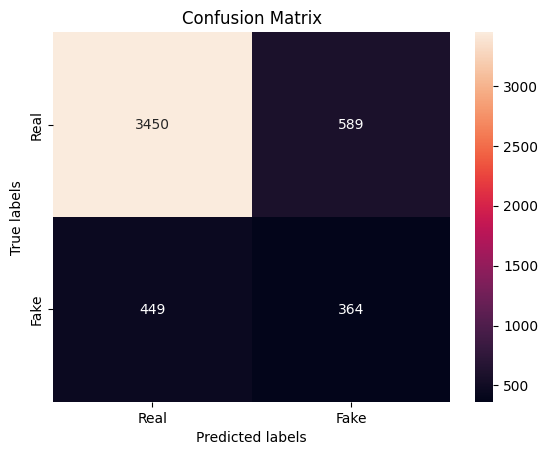

In [34]:
print("Best Score: ", trial.params)
bestParams = trial.params
model = xgb.XGBClassifier(**bestParams)
model.fit(X_train, y_train)
y_pred_xg = model.predict(x_test_validate)

cm = confusion_matrix(y_test_validate, y_pred_xg)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g',ax = ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Real', 'Fake'])
ax.yaxis.set_ticklabels(['Real', 'Fake'])

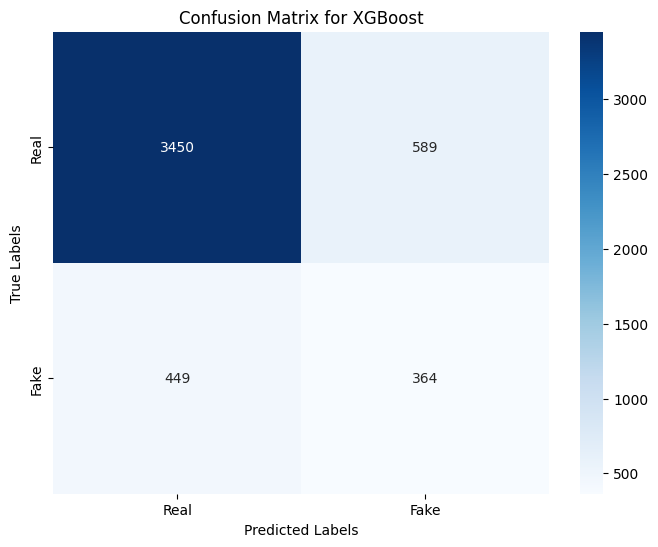

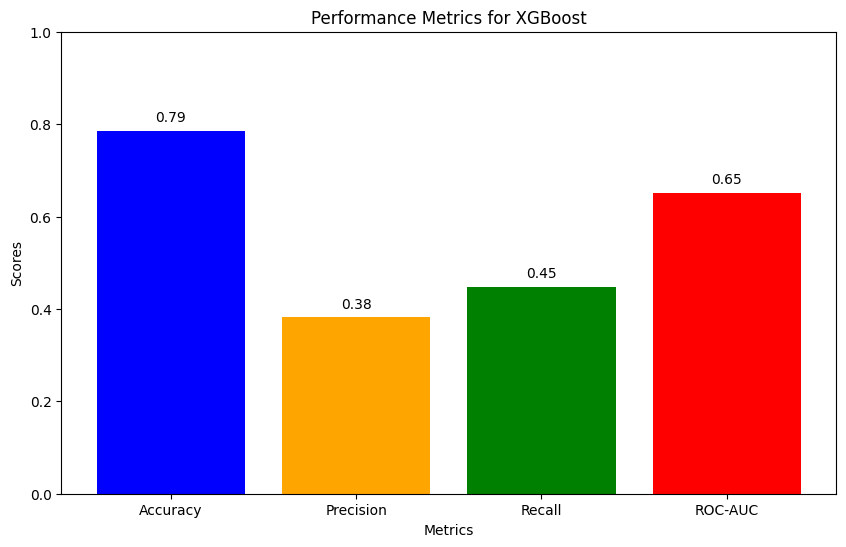

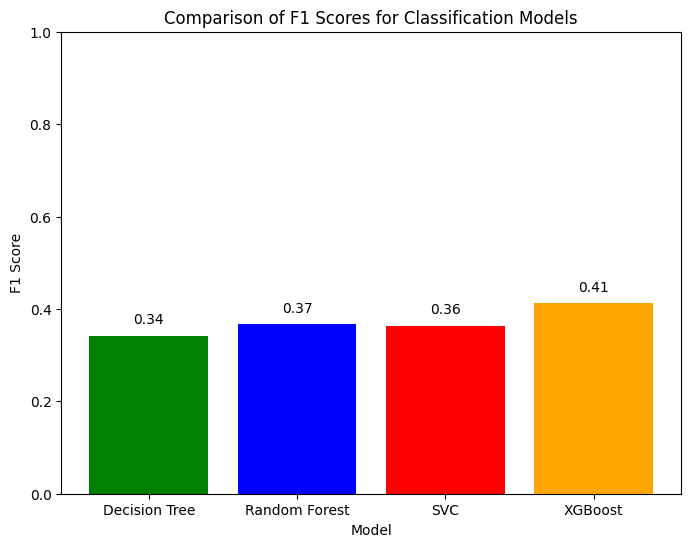

In [35]:
best_accuracy = accuracy_score(y_test_validate, y_pred_xg)
best_precision = precision_score(y_test_validate, y_pred_xg)
best_recall = recall_score(y_test_validate, y_pred_xg)
best_roc_auc = roc_auc_score(y_test_validate, y_pred_xg)

# Generate the confusion matrix
cm = confusion_matrix(y_test_validate, y_pred_xg)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

scores = [best_accuracy, best_precision, best_recall, best_roc_auc]
score_labels = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']

plt.figure(figsize=(10, 6))
plt.bar(score_labels, scores, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics for XGBoost')
plt.ylim(0, 1)  # Assuming the scores are between 0 and 1
for i in range(len(scores)):
    plt.text(i, scores[i] + 0.02, f'{scores[i]:.2f}', ha = 'center')
plt.show()

f1_dt = f1_score(y_test_validate, y_pred_dt)
f1_rf = f1_score(y_test_validate, y_pred_rf)
f1_xg = f1_score(y_test_validate, y_pred_xg)
f1_svc = f1_score(y_test_validate, y_pred_svc)

models = ['Decision Tree', 'Random Forest', 'SVC', 'XGBoost']
f1_scores = [f1_dt, f1_rf, f1_svc, f1_xg]

plt.figure(figsize=(8, 6))
plt.bar(models, f1_scores, color=['green', 'blue', 'red', 'orange'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Classification Models')
plt.ylim(0, 1)

# Add the text with the F1 score on top of each bar
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')


In [ ]:
import pickle
file_name = "fakeReviewDetectionModel.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

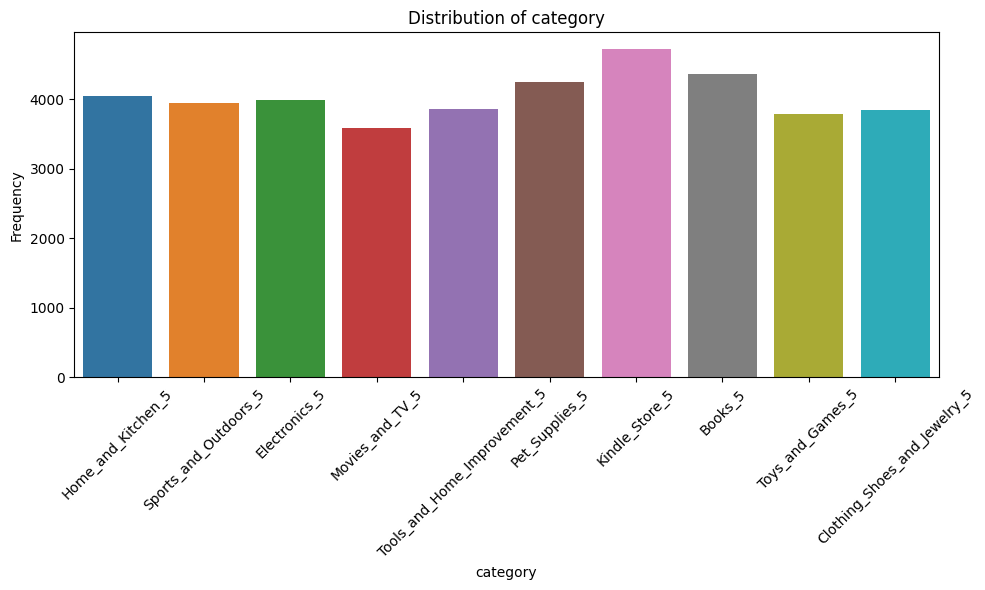

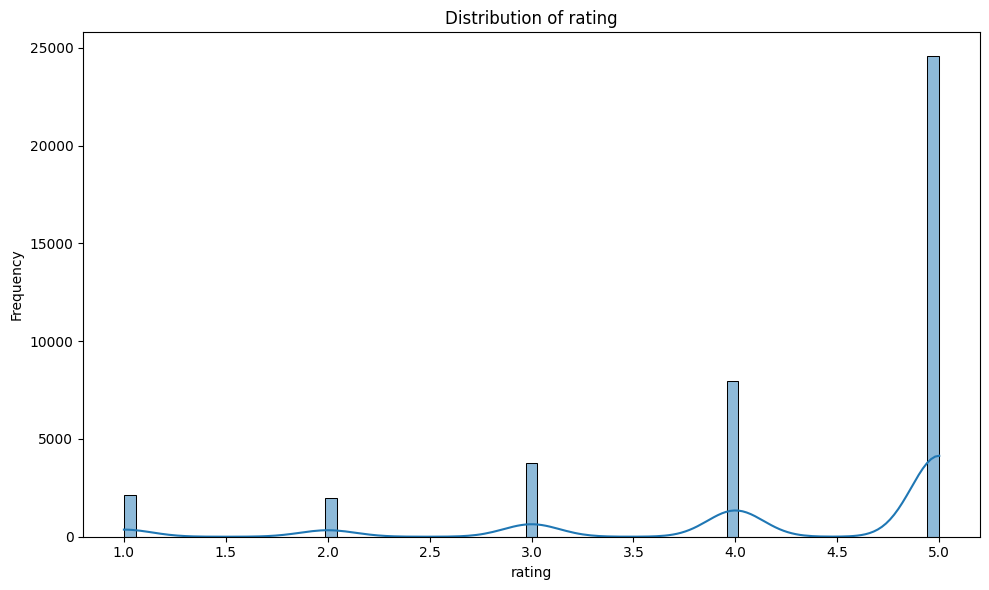

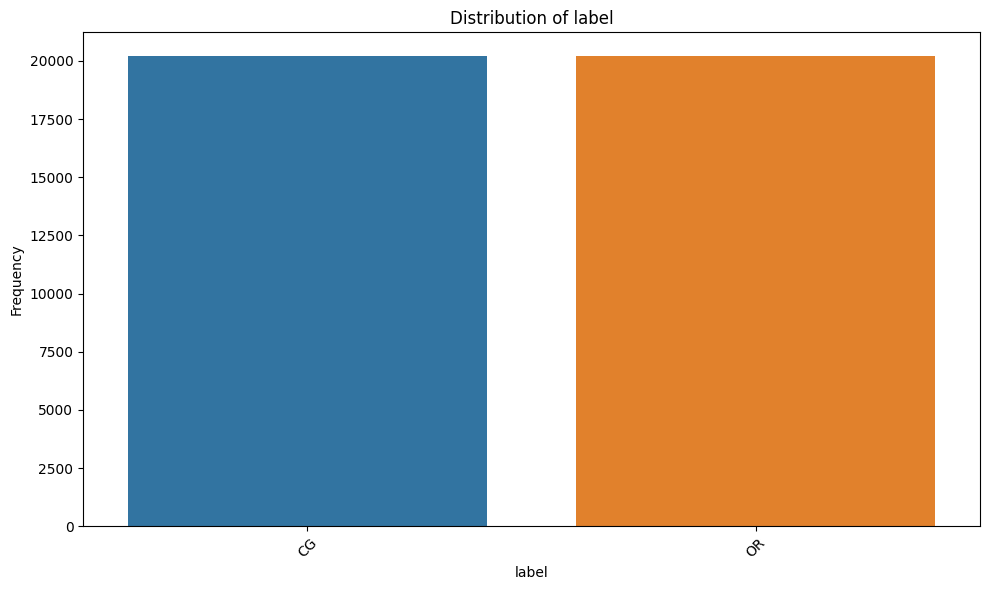

ValueError: ignored

Error in callback <function _draw_all_if_interactive at 0x7942c11d9d80> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1000x600 with 1 Axes>

In [ ]:
data = pd.read_csv('/fake_reviews_dataset.csv')

columns = data.columns

for column in columns:
    plt.figure(figsize=(10, 6))

    if data[column].dtype == 'object':
        sns.countplot(x=column, data=data)
        plt.xticks(rotation=45)
    else:
        sns.histplot(data[column], kde=True)

    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

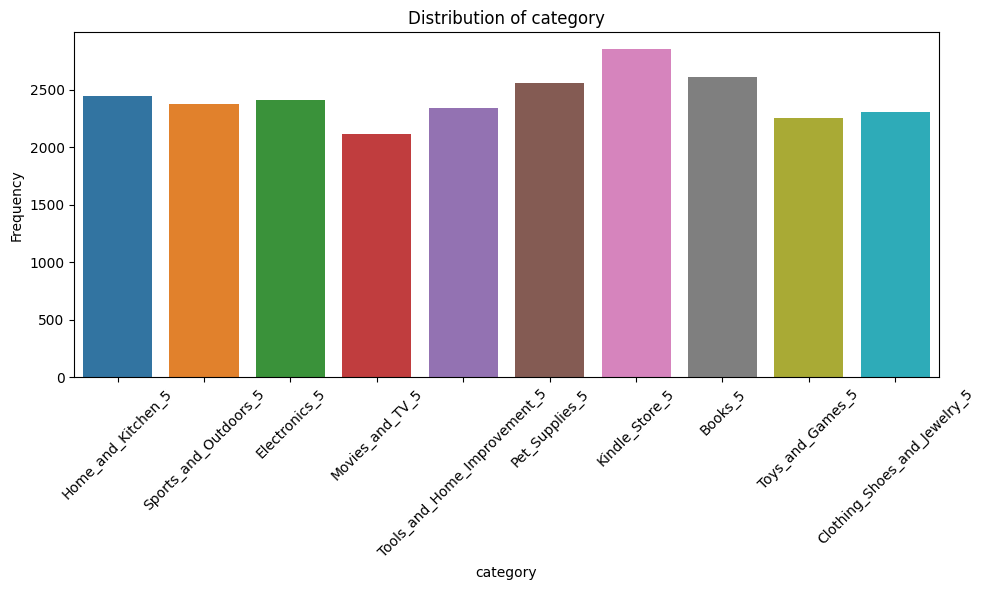

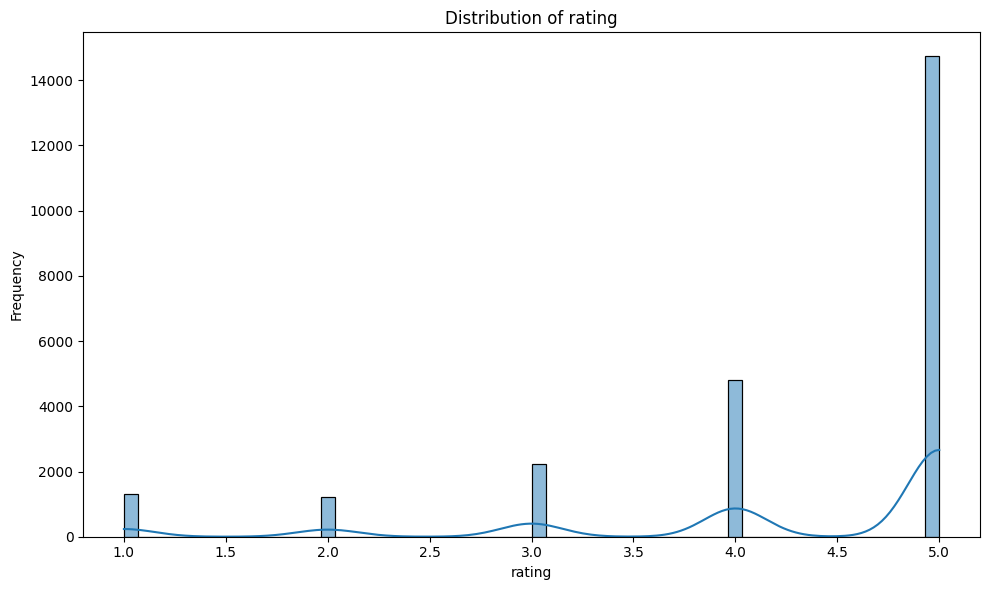

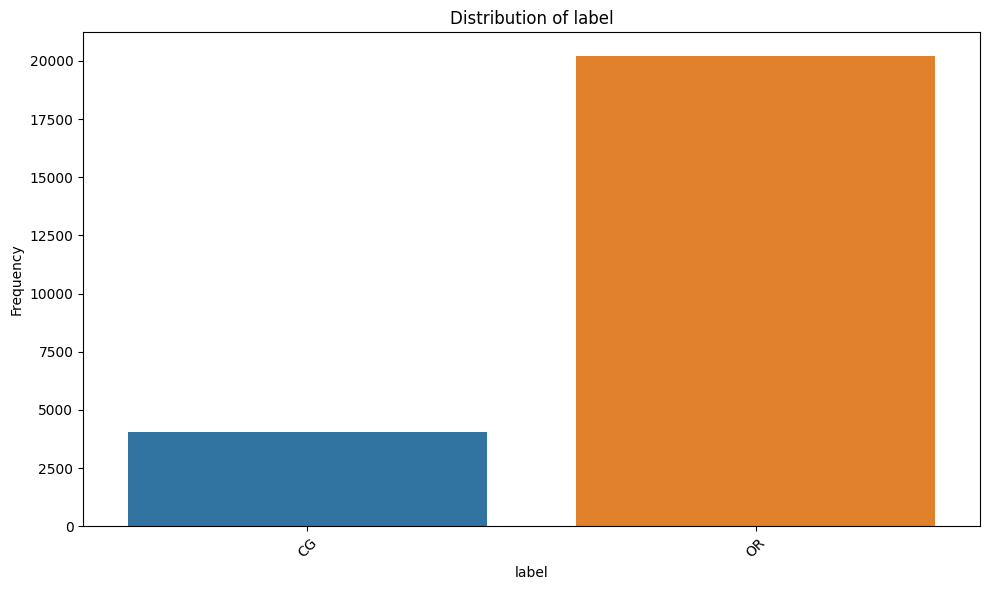

ValueError: ignored

Error in callback <function _draw_all_if_interactive at 0x7942c11d9d80> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1000x600 with 1 Axes>

In [ ]:
data = pd.read_csv('/cleaned_reviews.csv')

columns = data.columns

for column in columns:
    plt.figure(figsize=(10, 6))

    if data[column].dtype == 'object':
        sns.countplot(x=column, data=data)
        plt.xticks(rotation=45)
    else:
        sns.histplot(data[column], kde=True)

    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()